# 分析流程

创建或打开模型
编辑修改和查看模型
Gap filling
模型计算FBA
FVA
敲除分析

用!pip install cobra语句命令在笔记本中即可直接执行python命令安装需要的包，不需要再打开terminal
仅执行一遍，服务器安装后不要再执行

In [ ]:
#!pip install cobra

## 创建打开模型

可打开cobra.test的内嵌模型 "ecoli" and "salmonella" "textbook"

In [1]:
from __future__ import print_function
import cobra
import cobra.test #内嵌模型
#from cobra.util.solver import linear_reaction_coefficients
# "ecoli" and "salmonella" are also valid arguments
model = cobra.test.create_test_model("textbook")
#model = cobra.test.create_test_model("ecoli")

从头新建模型可用下列命令，但需逐一添加反应代谢物很麻烦，因此模型构建编辑最好在excel中进行，然后转成sbml文件导入。

In [ ]:
import os
from os.path import join
data_dir = cobra.test.data_dir
#C:\Users\yahan\Anaconda3\Lib\site-packages\cobra\test\data
model=cobra.io.read_sbml_model(join(data_dir, "ijo1366.xml"))
model = read_sbml_model('data/iJO1366.xml.gz')#直接读取压缩文件
#cobra.io.write_sbml_model(model, "test_cobra.xml", use_fbc_package=False) #写模型
#!wget http://bigg.ucsd.edu/static/models/iJO1366.xml #从网络直接下载模型

## 查看编辑修改模型

查看反应、代谢物和基因个数，查看具体反应代谢物信息最好在excel表格中

In [ ]:
nr=len(model.reactions)
print(len(model.metabolites))
print(len(model.genes))
print(model.compartments)

检查某一反应方程是否满足物料平衡（需要代谢物有相关化学式等信息）

In [8]:
pgi = model.reactions.get_by_id("PGI")
print(pgi.build_reaction_string())
pgi.check_mass_balance()

g6p_c <=> f6p_c


{}

可检索搜索模型中代谢物和反应，如下例搜索名字中包含glucose的所有代谢物

In [ ]:
model.metabolites.query('glucose', 'name')

检查模型中的边界条件，即哪些反应速率受限制，糖，氧等

In [6]:
print(model.medium)

{'EX_co2_e': 1000.0, 'EX_glc__D_e': 10.0, 'EX_h_e': 1000.0, 'EX_h2o_e': 1000.0, 'EX_nh4_e': 1000.0, 'EX_o2_e': 1000.0, 'EX_pi_e': 1000.0}


检查一个代谢物参与反应的个数

In [ ]:
g6p=model.metabolites.get_by_id("g6p_c")
len(g6p.reactions)

某一反应的相关基因及某一基因的相关反应，基因和反应间的关系

In [ ]:
pgi.genes
pgi_gene = model.genes.get_by_id("b4025")
pgi_gene.reactions
pgi.gene_reaction_rule

基因敲除可采用 `delete_model_genes` 函数，基于GPR修改相应反应的上下限为0，同时可以设定cumulative_deletions参数来确定是单基因敲除还是累积敲除。undelete_model_genes函数复原敲除基因 

In [ ]:
cobra.manipulation.delete_model_genes(model, ["b4025"], cumulative_deletions=True)
cobra.manipulation.undelete_model_genes(model)

## block reaction analysis

In [ ]:
cobra.flux_analysis.variability.find_blocked_reactions(model, reaction_list=None, zero_cutoff=1e-09, open_exchanges=False)

## FBA分析

设定目标函数，约束条件（除了计量约束外可添加任意新的约束关系），选择求解器，求解

In [ ]:
model = cobra.test.create_test_model("textbook")
model.objective
model.objective.expression#目标反应常表示为其正反应减去其逆反应
#model.objective = 'ATPM' #新目标函数
model.objective = {model.reactions.Biomass_Ecoli_core: 1}

In [ ]:
以某一目标产物生成速率为优化目标

In [ ]:
product=model.metabolites.get_by_id('thr__L_c')
demand =model.add_boundary(product, type='demand') #add demand reaction as the objective
model.objective = demand
model.optimize().objective_value

计算一系列目标产物的反应速率,利用with每次更改目标后自动改回，待验证

In [ ]:
with model:
    for p in product_list:
        product=model.metabolites.get_by_id(p)
        model.objective = model.add_boundary(product, type='demand')
        model.optimize().objective_value

In [ ]:
#新约束使两反应FBA和NH4t相同速率
same_flux = model.problem.Constraint(model.reactions.FBA.flux_expression - model.reactions.NH4t.flux_expression,lb=0,ub=0)
model.add_cons_vars(same_flux)
#约束使生长速率不小于0.1，也可以直接修改反应下限实现
co = model.problem.Constraint(model.reactions.Biomass_Ecoli_core.flux_expression, lb=0.1) 
model.add_cons_vars([co])
#等同下面语句
model.reactions.Biomass_Ecoli_core.lower_bound=0.1

可检查模型的计量矩阵等

{'EX_co2_e': 1000.0, 'EX_glc__D_e': 10.0, 'EX_h_e': 1000.0, 'EX_h2o_e': 1000.0, 'EX_nh4_e': 1000.0, 'EX_o2_e': 1000.0, 'EX_pi_e': 1000.0}


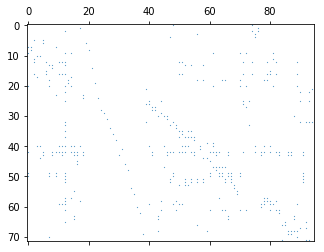

In [5]:
#print(str(model.solver)) #将模型转化为约束优化的数学方程表示
#直接将问题数学化以应用通用的约束优化方法求解
cobra.util.array.constraint_matrices(model, array_type='dense', include_vars=False, zero_tol=1e-06) 
stoich_matrix = cobra.util.create_stoichiometric_matrix(model, array_type='dense', dtype=None)#生成计量矩阵，返回一numpy array
#array——type if ‘dense’, return a standard numpy.array, ‘dok’, or ‘lil’ will construct a sparse array using scipy
#and ‘DataFrame’ will give a pandas DataFrame with metabolite indices and reaction columns
cobra.util.array.nullspace(stoich_matrix, atol=1e-13, rtol=0) #计算零空间
%matplotlib inline
import matplotlib.pyplot as plt
plt.spy(stoich_matrix, precision=0.01, markersize=.2) #直接对计量矩阵可视化

In [2]:
solution = model.optimize()
model.slim_optimize() #计算更快，只返回目标值
model.objective.value
solution.fluxes['FBA']
model.summary() #给出输入输出通量
model.metabolites.nadh_c.summary() #该代谢物相关通量

IN FLUXES        OUT FLUXES    OBJECTIVES
---------------  ------------  ----------------------
o2_e      21.8   h2o_e  29.2   Biomass_Ecol...  0.874
glc__D_e  10     co2_e  22.8
nh4_e      4.77  h_e    17.5
pi_e       3.21
PRODUCING REACTIONS -- Nicotinamide adenine dinucleotide - reduced (nadh_c)
---------------------------------------------------------------------------
%       FLUX  RXN ID      REACTION
----  ------  ----------  --------------------------------------------------
42%    16     GAPD        g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c
24%     9.28  PDH         coa_c + nad_c + pyr_c --> accoa_c + co2_c + nadh_c
13%     5.06  AKGDH       akg_c + coa_c + nad_c --> co2_c + nadh_c + succ...
13%     5.06  MDH         mal__L_c + nad_c <=> h_c + nadh_c + oaa_c
8%      3.1   Biomass...  1.496 3pg_c + 3.7478 accoa_c + 59.81 atp_c + 0....

CONSUMING REACTIONS -- Nicotinamide adenine dinucleotide - reduced (nadh_c)
--------------------------------------------------------------

## CPLEX求解器

缺省求解器为glpk,但其性能不如cplex且不支持复杂约束条件，
从[IBM网站](https://www.ibm.com/analytics/data-science/prescriptive-analytics/cplex-optimizer)下载学术版CPLEX Optimization Studio并安装
!conda install -c IBMDecisionOptimization docplex cplex
可求解非线性约束，复杂目标函数如 **min** $\frac{1}{2}\left(x^2 + y^2 \right) - y$只能通过cplex求解，公式采用latex[语法](http://data-blog.udacity.com/posts/2016/10/latex-primer/)。

In [ ]:
import cplex
model.solver = 'cplex'
#model.solver = 'glpk' #glpk只支持线性目标，因此对复杂目标函数需cplex求解器
quadratic_objective = model.problem.Objective(
    0.5 * model.reactions.NH4t.flux_expression**2 + 0.5 *
    model.reactions.FBA.flux_expression**2 -
    model.reactions.FBA.flux_expression,
    direction='min')
#model.objective = quadratic_objective
solution = model.optimize()

模型优化计算结果输出

In [ ]:
print(solution.fluxes.BIOMASS_Ec_iJO1366_core_53p95M)
#输出到一个dataframe进行处理
solution_frame = solution.to_frame()
solution_frame[solution_frame.fluxes.abs() > 1e-4]
#model.solver.variables.difference.primal #需要检验

loopless FBA。

In [ ]:
%matplotlib inline
import plot_helper
import pandas
from cobra.flux_analysis.loopless import add_loopless, loopless_solution
from cobra.flux_analysis import pfba
nominal = model.optimize()
loopless = loopless_solution(model)
df = pandas.DataFrame(dict(loopless=loopless.fluxes, nominal=nominal.fluxes))
df.plot.scatter(x='loopless', y='nominal')

PFBA使通量和最小，Parsimonious，minimize the total sum of absolute flux values
需要核对一下PFBA的通量和是否是针对碳通量的，只有碳通量和（针对碳原子数给权重）才有意义，另外酶子集合并，长短途径也可能对结果有影响，应该修正？
FBA的结果应针对碳原子数修正，才能得到真正的碳流分布，实现算法，反应的碳权重是所有反应物或所有产物的碳原子个数之和，而不是针对某一特定底物，可以推广到一元素流网络，特别是碳氮磷硫流。

In [ ]:
from cobra.flux_analysis import pfba
pfba_solution = pfba(model) #PFBA使通量和最小
pfba_solution = pfba(model, fraction_of_optimum=0.95) #可计算通量值为最优值的0.95倍范围时的通量和最小解
print(pfba_solution.fluxes.abs().sum())

## FVA

In [ ]:
from cobra.flux_analysis import flux_variability_analysis
a=flux_variability_analysis(model)
abs_flux_ranges = abs(a.maximum - a.minimum).to_dict()
a=flux_variability_analysis(model, loopless=True) #去掉无效循环
a=flux_variability_analysis(core_model, fraction_of_optimum=0.9, pfba_factor=1.1, loopless=True)
#fraction_of_optimum设定最优速率不小于该值，pfba_factor设定总通量和不高于最小通量和的倍数（过高通量实际不可能）

In [ ]:
flux_variability_analysis(model, model.reactions[:10])
flux_variability_analysis(model, model.reactions[:10], fraction_of_optimum=0.9) #90%最优值
loop_reactions = [model.reactions.FRD7, model.reactions.SUCDi]
flux_variability_analysis(model, reaction_list=loop_reactions, loopless=True)
#对FVA可应用 loopless=True 参数使得到最大最小值更合理，但需人为给定loop反应
model.summary(fva=0.95) #FVA时的输入输出通量

## 敲除分析

应用with model功能, 可以循环敲除或修改某一反应的边界条件，每次修改计算后该敲除或条件改变操作会自动恢复以进行下一次计算

In [ ]:
model = cobra.test.create_test_model('textbook')
with model:
    for reaction in model.reactions:
        reaction.knock_out()
        model.optimize()
        print('%s blocked (bounds: %s), new growth rate %f' %
              (reaction.id, str(reaction.bounds), model.objective.value))
    for gene in model.genes[:5]:
        gene.knock_out()
        model.optimize()
        print('%s blocked, new growth rate %f' %
              (gene.id,  model.objective.value))
reas=model.reactions
with model:
    for i in range(len(reas)):
        reas[i].lower_bound=x[i] #根据一向量x中的值改变边界条件，x可与表达数据等相关
        model.optimize()
        

Nested contexts are also supported

In [ ]:
print('original objective: ', model.objective.expression)
with model:
    model.objective = 'ATPM'
    print('print objective in first context:', model.objective.expression)
    with model:
        model.objective = 'ACALD'
        print('print objective in second context:', model.objective.expression)
    print('objective after exiting second context:',
          model.objective.expression)
print('back to original objective:', model.objective.expression)

更简单的敲除计算

In [ ]:
import pandas
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)
deletion_results = single_gene_deletion(model)
#下面语句给出必须基因列表（敲除后通量小于一阈值或无最优解
set(gene_deletions[(deletion_results.flux < 0.01) | (deletion_results.status != 'optimal')].index)
#也可使用下面更简单语句
from cobra.flux_analysis import find_essential_genes,find_essential_reactions
find_essential_genes(model,threshold=0.01)

#rdeletion_results = single_reaction_deletion(model, model.reactions[:20]) #对反应敲除类似

双基因敲除

In [ ]:
double_gene_deletion(model, model.genes[-5:], return_frame=True, number_of_processes=2).round(4)
#return_frame=True will cause them to format the results as a pandas.DataFrame,现在return_frame和number_of_processes两个参数不识别
#number_of_processes 确定用几个核心计算，缺省值为4

## MOMA, 敲除后使通量变化最小

In [ ]:
deletion_results = single_gene_deletion(model,method='linear moma')
#method可选{"fba", "moma", "linear moma"}

## 改变培养基组成计算

In [ ]:
medium = model.medium #改变培养基组成计算
with model:
    medium['EX_glc__D_e'] = 0 #葡萄糖换成琥珀酸，应根据碳原子个数修改使碳输入通量相同以比较
    medium['EX_succ_e'] = 10
    model.medium = medium
    solution = model.optimize()
    print(solution.fluxes['BIOMASS_Ecoli_core_w_GAM'])        

## 表型相平面分析

分析两个不同输入（糖和氧）下最优速率的变化，需要看一下是将输入固定在该值还是固定上限？
还可以分析产物生成和生长间的关系

In [ ]:
from cobra.flux_analysis import production_envelope
model = cobra.test.create_test_model("textbook")
prod_env = production_envelope(model, ["EX_glc__D_e", "EX_o2_e"])
#给出carbon_sources参数时同时计算产物得率
#prod_env = production_envelope(model, ["EX_o2_e"], objective="EX_ac_e", carbon_sources="EX_glc__D_e") 
res=prod_env.head() #获得分析结果
%matplotlib inline #前面加%以在下面输出图像
prod_env.plot(kind='line', x='EX_o2_e', y='carbon_yield_maximum');

In [ ]:
prod_env = production_envelope(model, reactions=model.reactions.BIOMASS_Ec_iJO1366_core_53p95M, 
                               objective=model.reactions.EX_ac_e)
#下面语句给出类似产物和生长偶联关系的曲线图
prod_env[prod_env.direction == 'maximum'].plot(kind='line', x='BIOMASS_Ec_iJO1366_core_53p95M', y='carbon_yield')

## Flux Samplling

通量空间样本随机取样，均满足约束条件

In [ ]:
from cobra.flux_analysis import sample
#model = cobra.test.create_test_model("textbook")
s = sample(model, 100)
s.head()
%time s = sample(model, 1000, processes=2) #两核心并行计算，缺省为单核
s = sample(model, 100, method="achr") #Hit-and-Run for sampling
